In [1]:
%pylab inline
import numpy as np
import sys
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

import sys
sys.path.append('../../core/')
from utils import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
loss_types = ['MSE', 'RE', 'OW','AOW']
taus = [2.0,4.0,6.0,8.0,10.0]
n_restarts = 20

In [3]:
Results = {}

def compute_output_dist(D):

    D_hist, D_bins = np.histogram(D, density = True, bins='auto')

    D_order = np.argsort(D)
    D_sorted = np.sort(D)
    inds = [np.min(np.where(D_sorted >= e)) for e in D_bins[:-1]] + [len(D)]

    D_density = np.zeros_like(D)
    for j in range(len(D_bins)-1):
        D_density[D_order[inds[j]:inds[j+1]]] = D_hist[j]
        
    return D_density

for loss_type in loss_types:
    for tau in taus:

        filename = '../../saved_results/kol/results_loss_'+loss_type+'_tau'+str(tau)+'.npy'
        Results[loss_type, tau] = np.load(filename, allow_pickle=True).item()

        Results[loss_type,tau]['NN_mean'] = np.mean(np.vstack([Results[loss_type, tau]['NN_'+str(j+1)] 
                                                     for j in range(n_restarts)]), axis=0)

        Results[loss_type,tau]['error'] = np.vstack([Results[loss_type, tau]['true'].flatten()-
                                                     Results[loss_type, tau]['NN_'+str(j+1)]
                                                     for j in range(n_restarts)])
        
        Results[loss_type,tau]['density'] = compute_output_dist(Results[loss_type, tau]['true'])

m = len(Results[loss_types[0],tau]['true'])
m_tv = int(0.6*len(Results[loss_types[0],tau]['true']))

In [4]:
Eps = np.linspace(np.min(np.log(Results[loss_types[0],taus[0]]['density']))+0.5,
                  np.max(np.log(Results[loss_types[0],taus[0]]['density'])),100)
Eps_MSE = {}
    
for tau in taus:
    for loss_type in tqdm(loss_types):
        
        Eps_MSE[loss_type,tau] = np.zeros((n_restarts, len(Eps)))
        
        for j in range(len(Eps)):
            S = np.where(np.log(Results[loss_type,tau]['density'][m_tv:]) <= Eps[j])[0]
            true = Results[loss_type, tau]['true'][m_tv:][S].flatten()
            Eps_MSE[loss_type,tau][:,j] = [np.mean((true - Results[loss_type, tau]['NN_'+str(j+1)][m_tv:][S])**2)
                                             for j in range(n_restarts)]

100%|██████████| 4/4 [00:00<00:00,  7.81it/s]


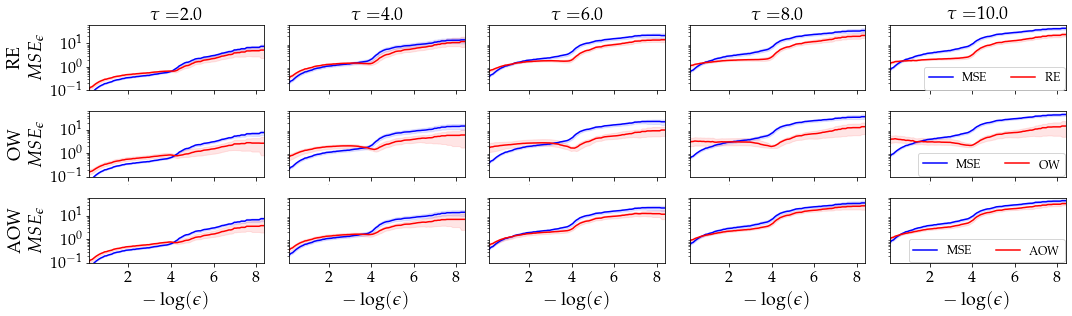

In [6]:
figure(figsize = (15,4.5))
label_fs = 18
alpha = 0.1
pct = 10

for i in range(len(taus)):
    for j in range(len(loss_types)-1):

        ax=subplot2grid((3,len(taus)),(j,i))
        
        plot(-Eps, np.mean(Eps_MSE[loss_types[0],taus[i]],axis=0), 'b', label='MSE')
        fill_between(-Eps, 
                     np.percentile(Eps_MSE[loss_types[0],taus[i]],pct,axis=0), 
                     np.percentile(Eps_MSE[loss_types[0],taus[i]],100-pct,axis=0), 
                     color='b', alpha=0.1)

        plot(-Eps, np.mean(Eps_MSE[loss_types[j+1],taus[i]],axis=0), 'r', label=loss_types[j+1])
        fill_between(-Eps, 
                     np.percentile(Eps_MSE[loss_types[j+1],taus[i]],pct,axis=0), 
                     np.percentile(Eps_MSE[loss_types[j+1],taus[i]],100-pct,axis=0), 
                     color='r', alpha=0.1)
        
        xlim(-Eps[-1], -Eps[0])
        yscale('log')
        ylim([0.1,60])

        if j==2:
            xlabel(r'$-\log(\epsilon)$', fontsize = label_fs)
            xticks(fontsize = label_fs-2)
        else:
            xticks(fontsize=0)
        if j==0:
            title(r'$\tau=$'+str(taus[i]), fontsize = label_fs)
#             legend(loc = 'upper left', fontsize = label_fs-6, ncol=2)

        if i==0:
            label = r'$MSE_\epsilon$'
            label = r''+loss_types[j+1]+'\n$MSE_\epsilon$'
            ylabel(label, fontsize = label_fs)
            yticks([0.1,1,10], fontsize = label_fs-2)
        else:
            yticks([], fontsize = label_fs-2)
        if i == len(taus)-1:
            legend(loc = 'lower right', fontsize = label_fs-6, ncol=2, bbox_to_anchor=(1.03, -0.08))

tight_layout()